# Data Exploration

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

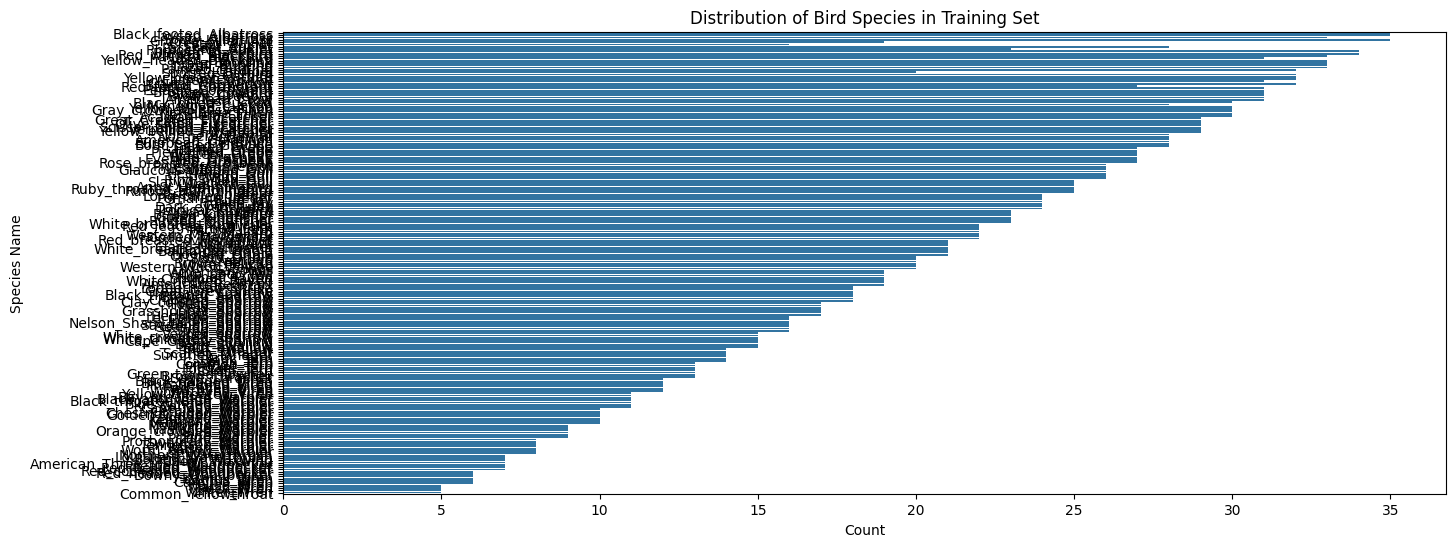

Text(0, 0.5, 'Count')

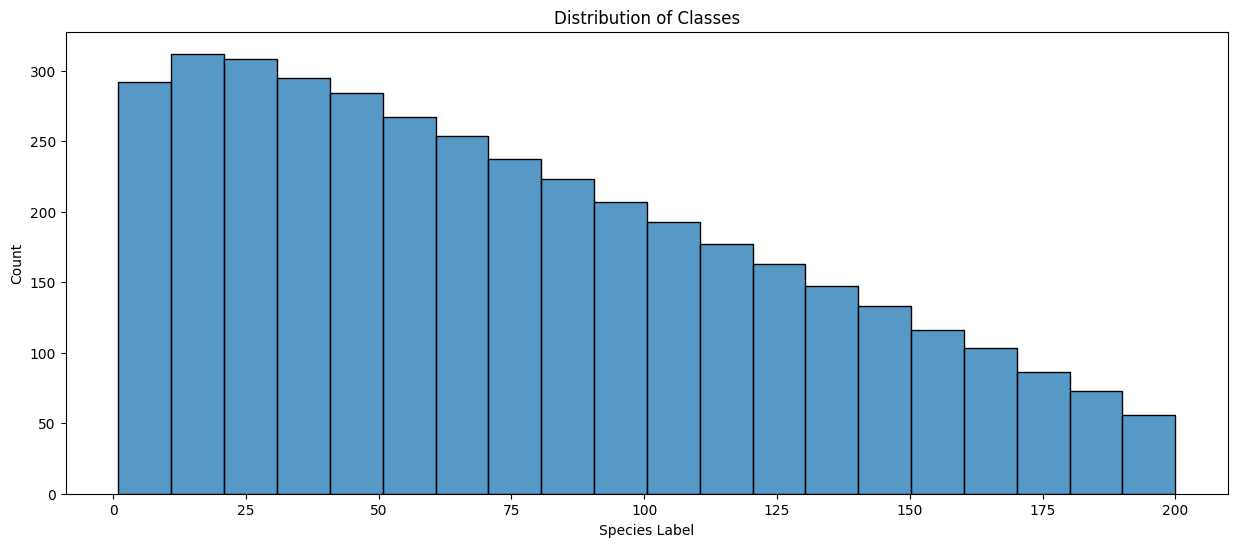

In [3]:
base_dir = Path('aml-2024-feather-in-focus')
class_names = np.load(base_dir / "class_names.npy", allow_pickle=True).item()
train_df = pd.read_csv(base_dir / 'train_images.csv')
test_df = pd.read_csv(base_dir / 'test_images_path.csv')
attributes = np.load(base_dir / 'attributes.npy', allow_pickle=True)

with open(base_dir / 'attributes.txt', 'r') as f:
    attributes_names = f.read().splitlines()

label_to_name = {v: k.split('.')[1] for k, v in class_names.items()}
train_df['bird_name'] = train_df['label'].map(label_to_name)

# class_distribution = train_df['label'].value_counts()
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=train_df, y='bird_name')
plt.title('Distribution of Bird Species in Training Set')
plt.xlabel('Count')
plt.ylabel('Species Name')
plt.show()

plt.figure(figsize=(15, 6))
sns.histplot(data=train_df, x='label')
plt.title('Distribution of Classes')
plt.xlabel('Species Label')
plt.ylabel('Count')

In [4]:
print(f'Number of classes: {len(train_df["bird_name"].unique())}')

Number of classes: 200


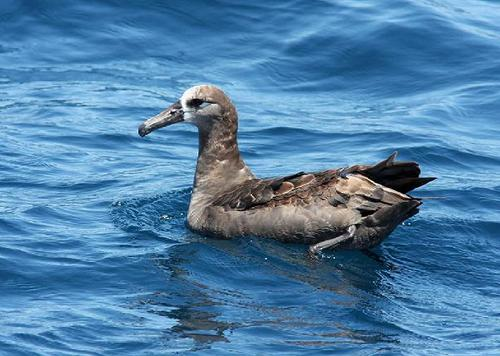

In [5]:
sample_path = train_df['image_path'].iloc[0].lstrip('/') 
sample_image_path = base_dir / 'train_images' / sample_path
sample_image = tf.keras.preprocessing.image.load_img(sample_image_path)
sample_image



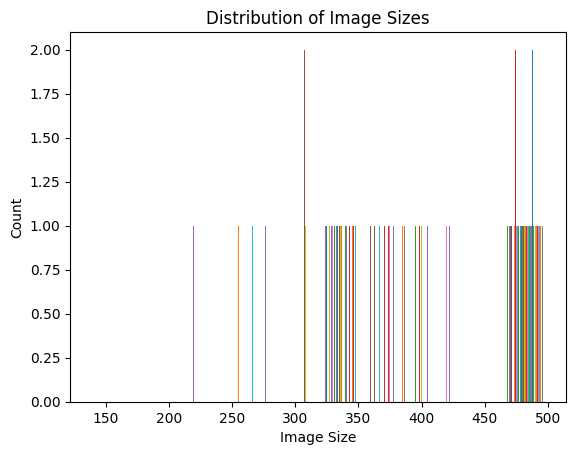

In [6]:
# check image size and format
image_sizes = []
for path in train_df['image_path'][:100]:
    clean_path = path.lstrip('/')
    full_path = base_dir / 'train_images' / clean_path
    img = tf.keras.preprocessing.image.load_img(full_path)
    image_sizes.append(img.size)


plt.hist(image_sizes)
plt.xlabel('Image Size')
plt.ylabel('Count')
plt.title('Distribution of Image Sizes')
plt.show()

In [8]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
inputs = processor(images=sample_image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

C:\Users\giorg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\giorg\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [110]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, ViTImageProcessor
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import tqdm

class csfsfccsxfcsxfsf(Dataset):
    def __init__(self, image_paths, labels, processor):
        """
        Custom dataset for bird images

        Args:
            image_paths (list): List of paths to bird images
            labels (list): Corresponding labels for images
            processor (ViTImageProcessor): Image processor for transformations
        """
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        # Process image using ViT image processor
        inputs = self.processor(images=image, return_tensors='pt')
        return {
            'pixel_values': inputs['pixel_values'].squeeze(),
            'labels': torch.tensor(self.labels[idx])
        }

def process_image_paths(df, path, train=True):
    """
    Process image paths by adding a base path and normalizing Windows paths

    Args:
        df (pandas.DataFrame): DataFrame containing image paths
        base_path (str): Base directory path to prepend to image paths
        path_column (str, optional): Name of the column containing image paths

    Returns:
        list: Full image paths with base path added and normalized
    """
    
    full_paths = []
    for i, path in enumerate(df):
        sample_path = df.iloc[i].lstrip('/')
        if train:
            sample_image_path = base_dir / 'train_images' / sample_path
        else:
            sample_image_path = base_dir / 'test_images' / sample_path
        full_paths.append(sample_image_path)

    # Combine base path with normalized image paths
    # full_paths = [
    #     os.path.normpath(os.path.join(base_path, normalize_path(path)))
    #     for path in df
    # ]

    return full_paths

def prepare_data(image_paths, labels=None, train=True):
    """
    Prepare data when you already have image paths and labels

    Args:
        image_paths (list): List of full paths to images
        labels (list): Corresponding labels for images

    Returns:
        tuple: image_paths, labels, and a dictionary mapping labels to indices
    """
    class_to_idx = {}
    integer_labels = None
    # Create a mapping of unique labels to integer indices
    if train:
        unique_labels = sorted(set(labels))
        class_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        # Convert string labels to integer indices
        integer_labels = [class_to_idx[label] for label in labels]

    base_dir = Path('C:\\Users\\giorg\\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\\Projects\\Python\\CLS\\Applied Machine Learning\\KaggleCompetition\\aml_2024_bird_feather\\aml-2024-feather-in-focus')
    image_paths = process_image_paths(image_paths, base_dir, train)
    # image_paths = [path.replace('\\', '/') for path in image_paths]

    return image_paths, integer_labels, class_to_idx

def fine_tune_vit(num_epochs=5, batch_size=16, learning_rate=2e-5):
    """
    Fine-tune Vision Transformer for bird classification

    Args:
        data_dir (str): Directory containing bird images
        num_epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        learning_rate (float): Learning rate for optimization
    """
    # Load pre-trained model and processor
    processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
    model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k',
        num_labels=len(train_df['bird_name'].unique()),
        ignore_mismatched_sizes=True
    )

    # Prepare data
    image_paths, labels, class_to_idx = prepare_data(train_df['image_path'], train_df['bird_name'])

    print(image_paths)
    # Split into train and validation sets
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42
    )

    # Create datasets
    train_dataset = BirdDataset(train_paths, train_labels, processor)
    val_dataset = BirdDataset(val_paths, val_labels, processor)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Prepare optimizer and learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Training loop
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device}')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm.tqdm(train_loader):
            optimizer.zero_grad()

            inputs = {k: v.to(device) for k, v in batch.items()
                      if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        # Validation
        model.eval()
        total_val_loss = 0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items()
                          if k != 'labels'}
                labels = batch['labels'].to(device)

                outputs = model(**inputs, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)
                correct_predictions += (predictions == labels).sum().item()
                total_predictions += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_predictions / total_predictions

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Save the fine-tuned model
    model.save_pretrained('./bird_classification_model')
    processor.save_pretrained('./bird_classification_model')

    return model, processor, class_to_idx

In [29]:
model, proc, class_to_idx = fine_tune_vit(num_epochs=25, batch_size=32, learning_rate=1e-4)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

Model Evaluation Metrics:
accuracy: 0.9572
f1_macro: 0.9550
f1_micro: 0.9572
f1_weighted: 0.9571
precision_macro: 0.9610
precision_micro: 0.9572
precision_weighted: 0.9597
recall_macro: 0.9531
recall_micro: 0.9572
recall_weighted: 0.9572

Detailed Classification Report:
                                precision    recall  f1-score   support

            Acadian_Flycatcher       0.87      0.87      0.87        30
                 American_Crow       0.85      0.90      0.88        31
            American_Goldfinch       1.00      1.00      1.00        28
                American_Pipit       0.95      1.00      0.97        19
             American_Redstart       0.95      1.00      0.97        19
American_Three_toed_Woodpecker       0.78      1.00      0.88         7
              Anna_Hummingbird       0.96      0.92      0.94        25
                    Artic_Tern       0.81      0.93      0.87        14
                 Baird_Sparrow       0.94      0.94      0.94        18
        

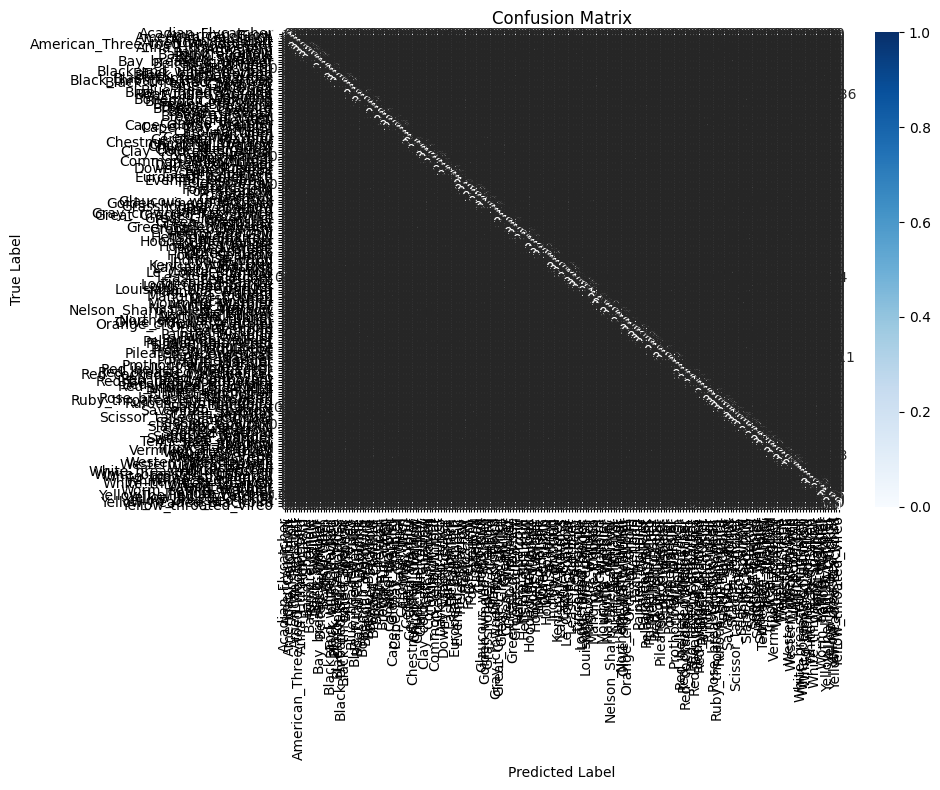

In [109]:
from sklearn.metrics import (
    f1_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    classification_report,
    accuracy_score
)

from transformers import ViTForImageClassification, ViTImageProcessor


def evaluate_model(model, val_loader, device=None):
    """
    Comprehensive model evaluation function
    
    Args:
        model (torch.nn.Module): Trained model
        val_loader (torch.utils.data.DataLoader): Validation data loader
        device (torch.device, optional): Device to run evaluation on
    
    Returns:
        dict: Comprehensive evaluation metrics
    """
    # Use GPU if available and not specified
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Prepare model for evaluation
    model.eval()
    model.to(device)
    
    # Lists to store predictions and true labels
    all_preds = []
    all_labels = []
    
    # Disable gradient calculation
    with torch.no_grad():
        for batch in val_loader:
            # Move inputs and labels to device
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(**inputs)
            
            # Get predictions
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_macro': f1_score(all_labels, all_preds, average='macro'),
        'f1_micro': f1_score(all_labels, all_preds, average='micro'),
        'f1_weighted': f1_score(all_labels, all_preds, average='weighted'),
        'precision_macro': precision_score(all_labels, all_preds, average='macro'),
        'precision_micro': precision_score(all_labels, all_preds, average='micro'),
        'precision_weighted': precision_score(all_labels, all_preds, average='weighted'),
        'recall_macro': recall_score(all_labels, all_preds, average='macro'),
        'recall_micro': recall_score(all_labels, all_preds, average='micro'),
        'recall_weighted': recall_score(all_labels, all_preds, average='weighted')
    }
    
    return metrics, all_preds, all_labels

def plot_confusion_matrix(all_labels, all_preds, class_names, normalize=True):
    """
    Create and plot confusion matrix
    
    Args:
        all_labels (list): True labels
        all_preds (list): Predicted labels
        class_names (list): List of class names
        normalize (bool): Whether to normalize confusion matrix
    
    Returns:
        matplotlib.figure.Figure: Confusion matrix plot
    """
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalize if requested
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    
    return plt.gcf()

def generate_classification_report(all_labels, all_preds, class_names):
    """
    Generate detailed classification report
    
    Args:
        all_labels (list): True labels
        all_preds (list): Predicted labels
        class_names (list): List of class names
    
    Returns:
        str: Detailed classification report
    """
    return classification_report(
        all_labels, 
        all_preds, 
        target_names=class_names
    )

# Example usage
def main(model, processor, class_to_idx, val_dataset):
    # Assume you have your model, validation loader, and class names
    # model, processor, class_to_idx = load_model()
    val_loader = DataLoader(val_dataset, batch_size=16)
    
    # Get class names (convert index to name)
    class_names = [k for k, v in sorted(class_to_idx.items(), key=lambda item: item[1])]
    
    # Evaluate model
    metrics, all_preds, all_labels = evaluate_model(model, val_loader)
    
    # Print metrics
    print("Model Evaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Plot confusion matrix
    cm_fig = plot_confusion_matrix(all_labels, all_preds, class_names)
    cm_fig.savefig('confusion_matrix.png')
    
    # Generate classification report
    report = generate_classification_report(all_labels, all_preds, class_names)
    print("\nDetailed Classification Report:")
    print(report)
    
    # Optional: Save report to file
    # with open('classification_report.txt', 'w') as f:
    #     f.write(report)

proc = ViTImageProcessor.from_pretrained('bird_classification_model')
model = ViTForImageClassification.from_pretrained(
    'bird_classification_model',
    num_labels=len(train_df['bird_name'].unique()),
    ignore_mismatched_sizes=True
)
test_df['bird_name'] = test_df['label'].map(label_to_name)
val_paths, val_labels, class_to_idx = prepare_data(train_df['image_path'], train_df['bird_name'], train=True)
val_dataset = BirdDataset(val_paths, val_labels, proc)
main(model, proc, class_to_idx, val_dataset)

In [132]:
train_df['bird_name']

0       Black_footed_Albatross
1       Black_footed_Albatross
2       Black_footed_Albatross
3       Black_footed_Albatross
4       Black_footed_Albatross
                 ...          
3921       Common_Yellowthroat
3922       Common_Yellowthroat
3923       Common_Yellowthroat
3924       Common_Yellowthroat
3925       Common_Yellowthroat
Name: bird_name, Length: 3926, dtype: object

In [89]:
class TestBirdDataset(Dataset):
    def __init__(self, image_paths, processor):
        """
        Custom dataset for bird images

        Args:
            image_paths (list): List of paths to bird images
            labels (list): Corresponding labels for images
            processor (ViTImageProcessor): Image processor for transformations
        """
        self.image_paths = image_paths
        self.processor = processor

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        image = Image.open(self.image_paths).convert('RGB')
        # Process image using ViT image processor
        inputs = self.processor(images=image, return_tensors='pt')
        return {
            'pixel_values': inputs['pixel_values'].squeeze()
        }

In [ ]:
# predict model on the test set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare model for evaluation
model.eval()
model.to(device)

all_preds = {}
test_paths, *_ = prepare_data(test_df['image_path'], train=True)

for n in range(len(test_paths)):

    test_dataset = TestBirdDataset(test_paths[n], proc)
    test_loader = DataLoader(test_dataset, batch_size=1)

    filenames = [str(test_paths).split('\\')[-1] for test_paths in test_paths]
    # print(filenames)
    
    with torch.no_grad():
        for b, batch in enumerate(test_loader):
                
                # Move inputs and labels to device
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                # labels = batch['labels'].to(device)
                # Forward pass
                outputs = model(**inputs)
                
                # Get predictions
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                
                preds = preds.cpu().numpy()
                print(preds)

                # Collect predictions and labels
                for i in range(len(preds)):
                    all_preds[filenames[n]] = preds[i]
            # all_labels.extend(labels.cpu().numpy())

[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[19]
[168]
[19]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[19]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[99]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[99]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[168]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[83]
[55]
[55]
[55]
[55]
[55]
[55]
[55]
[55]
[55]
[55]
[55]
[55]
[55]
[55]
[126]
[55]
[55]
[55]
[55]
[102]
[102]
[102]
[102]
[102]
[102]
[102]
[102]
[102]
[102]
[102]
[102]
[102]
[102]
[102]
[102]
[129]
[129]
[129]
[129]
[129]
[129]
[129]
[129]
[129]
[129]
[150]
[129]
[129]
[129]
[

KeyboardInterrupt: 

In [105]:
print(filenames)

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.jpg', '86.jpg', '87.jpg', '88.jpg', '89.jpg', '90.jpg', '91.jpg', '92.jpg', '93.jpg', '94.jpg', '95.jpg', '96.jpg', '97.jpg', '98.jpg', '99.jpg', '100.jpg', '101.jp

In [213]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class TestBirdDataset(Dataset):
    def __init__(self, image_paths, processor):
        # Convert paths to strings if they're WindowsPath objects
        self.image_paths = [str(path) for path in image_paths]
        self.processor = processor
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Open image and process
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        inputs = self.processor(images=image, return_tensors='pt')
        
        return {
            'pixel_values': inputs['pixel_values'].squeeze(),
            'image_path': image_path  # or filename if you prefer
        }

def predict_images(model, processor, image_paths, class_to_idx, batch_size=16):
    """
    Predict labels for a set of images
    
    Args:
        model (ViTForImageClassification): Trained model
        processor (ViTImageProcessor): Image processor
        image_paths (list): List of image file paths
        class_to_idx (dict): Mapping of class indices to labels
        batch_size (int, optional): Batch size for prediction
    
    Returns:
        dict: Mapping of image filenames to predicted labels
    """
    # Prepare device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    # Create dataset and dataloader
    test_dataset = TestBirdDataset(image_paths, processor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Prepare for predictions
    predictions = {}
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    # Predict
    with torch.no_grad():
        for batch in test_loader:
            # Prepare inputs
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'image_path'}
            
            # Get predictions
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            # Map predictions to class names
            batch_preds = preds.cpu().numpy()
            batch_paths = batch['image_path']
            
            # Store predictions with filenames
            for path, pred in zip(batch_paths, batch_preds):
                filename = os.path.basename(path)
                predictions[filename] = idx_to_class[pred]
    
    return predictions

# Example usage
def main():
    # Load model and processor
    unique_labels = sorted(train_df['bird_name'].unique())
    class_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    processor = ViTImageProcessor.from_pretrained('bird_classification_model')
    model = ViTForImageClassification.from_pretrained(
        'bird_classification_model',
        num_labels=len(train_df['bird_name'].unique()),
        ignore_mismatched_sizes=True
    )
    
    # Prepare image paths
    image_paths, *_ = prepare_data(test_df['image_path'], train=False)

    
    # Get predictions
    predictions = predict_images(model, processor, image_paths, class_to_idx)
    
    # Create DataFrame with predictions
    results_df = pd.DataFrame.from_dict(predictions, orient='index', columns=['predicted_label'])
    results_df.index.name = 'filename'
    results_df.reset_index(inplace=True)
    
    return results_df, class_to_idx

In [214]:
df, class_to_idx = main()

In [215]:
class_to_idx

{'Acadian_Flycatcher': 0,
 'American_Crow': 1,
 'American_Goldfinch': 2,
 'American_Pipit': 3,
 'American_Redstart': 4,
 'American_Three_toed_Woodpecker': 5,
 'Anna_Hummingbird': 6,
 'Artic_Tern': 7,
 'Baird_Sparrow': 8,
 'Baltimore_Oriole': 9,
 'Bank_Swallow': 10,
 'Barn_Swallow': 11,
 'Bay_breasted_Warbler': 12,
 'Belted_Kingfisher': 13,
 'Bewick_Wren': 14,
 'Black_Tern': 15,
 'Black_and_white_Warbler': 16,
 'Black_billed_Cuckoo': 17,
 'Black_capped_Vireo': 18,
 'Black_footed_Albatross': 19,
 'Black_throated_Blue_Warbler': 20,
 'Black_throated_Sparrow': 21,
 'Blue_Grosbeak': 22,
 'Blue_Jay': 23,
 'Blue_headed_Vireo': 24,
 'Blue_winged_Warbler': 25,
 'Boat_tailed_Grackle': 26,
 'Bobolink': 27,
 'Bohemian_Waxwing': 28,
 'Brandt_Cormorant': 29,
 'Brewer_Blackbird': 30,
 'Brewer_Sparrow': 31,
 'Bronzed_Cowbird': 32,
 'Brown_Creeper': 33,
 'Brown_Pelican': 34,
 'Brown_Thrasher': 35,
 'Cactus_Wren': 36,
 'California_Gull': 37,
 'Canada_Warbler': 38,
 'Cape_Glossy_Starling': 39,
 'Cape_May_

In [216]:
true_class_to_idx = train_df['bird_name'].unique()

In [217]:
true_class_to_idx[66]

'Anna_Hummingbird'

In [218]:
df.head()

,filename,predicted_label
0,999.jpg,Anna_Hummingbird
1,998.jpg,Great_Crested_Flycatcher
2,997.jpg,Florida_Jay
3,996.jpg,Yellow_headed_Blackbird
4,995.jpg,Florida_Jay


In [229]:
df[df['filename'] == '5.jpg']['predicted_label']

554    Bank_Swallow
Name: predicted_label, dtype: object

In [202]:
for l, label in enumerate(true_class_to_idx):
    df['predicted_label'][df['predicted_label'] == label] = l + 1

In [207]:
df.head()

,filename,predicted_label
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1


In [208]:
# write all_pred to test_images_sample.csv
pred_df = df.copy()
pred_df['predicted_label'] = pred_df['predicted_label']
pred_df = pred_df.rename(columns={'filename': 'id', 'predicted_label': 'label'})
pred_df['id'] = pred_df['id'].apply(lambda x: x.replace('.jpg', ''))

In [209]:
pred_df[pred_df['label'] == 67]

,id,label
1912,1913,67
1913,1914,67
1914,1915,67
1915,1916,67
1917,1918,67
1918,1919,67
1919,1920,67
1920,1921,67
1921,1922,67
1923,1924,67


In [210]:
pred_df.head()

,id,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [211]:
len(pred_df.index)

3926

In [212]:
pred_df.to_csv('train_images_sample4.csv', index=False)